In [1]:
import pandas as pd
np = pd.np
import pylab as plt
import seaborn as sns
from tsfresh import extract_features
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn import ensemble
from sklearn import manifold
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima_model import ARIMA
import warnings



# keras imports# keras 
from keras import backend as K
from keras import layers
from keras.models import Sequential
import keras.callbacks

# start interactive session
if K.backend() == 'tensorflow':
    sess = K.tf.InteractiveSession()

warnings.filterwarnings('ignore')
%matplotlib inline

/usr/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Metric

In [2]:
# SMAPE as Kaggle calculates it
def smape(true, predicted):
    true_o = true
    pred_o = predicted
    summ = np.abs(true_o) + np.abs(pred_o)
    smape = np.where(summ==0, 0, np.abs(pred_o - true_o) / summ)
    return np.mean(smape) * 200

# Loading data

In [3]:
# load data
temp_data0 = pd.read_csv('train_1.csv.zip',compression='zip')
#temp_data1 = pd.read_csv('train_2.csv.zip',compression='zip')
#split page out
page_details = pd.DataFrame([['_'.join(i.split('_')[:-3])]+i.split("_")[-3:] for i in temp_data0["Page"]])
page_details.columns = ["name","project", "access", "agent"]
#page_details['Page'] = temp_data0.Page
temp_data0 = temp_data0.join(page_details).sample(10000)
temp_data0.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,name,project,access,agent
60829,旗木卡卡西_zh.wikipedia.org_desktop_all-agents,310.0,363.0,374.0,313.0,266.0,321.0,295.0,360.0,371.0,...,360.0,215.0,321.0,160.0,169.0,157.0,旗木卡卡西,zh.wikipedia.org,desktop,all-agents
19251,"Бекинсэйл,_Кейт_ru.wikipedia.org_mobile-web_al...",210.0,187.0,298.0,368.0,347.0,394.0,272.0,240.0,299.0,...,728.0,579.0,652.0,610.0,621.0,435.0,"Бекинсэйл,_Кейт",ru.wikipedia.org,mobile-web,all-agents
132459,春一番_ja.wikipedia.org_all-access_spider,3.0,0.0,1.0,2.0,2.0,4.0,2.0,0.0,4.0,...,3.0,10.0,12.0,7.0,2.0,4.0,春一番,ja.wikipedia.org,all-access,spider
124678,"Алибасов,_Бари_Каримович_ru.wikipedia.org_all-...",5.0,6.0,5.0,5.0,4.0,5.0,5.0,5.0,11.0,...,3.0,5.0,9.0,7.0,7.0,12.0,"Алибасов,_Бари_Каримович",ru.wikipedia.org,all-access,spider
71620,Nadia_Comăneci_es.wikipedia.org_desktop_all-ag...,169.0,235.0,125.0,118.0,136.0,216.0,229.0,178.0,170.0,...,80.0,98.0,91.0,106.0,69.0,63.0,Nadia_Comăneci,es.wikipedia.org,desktop,all-agents


In [4]:
#temp_data0 = temp_data0.query(f'access=="desktop"')

In [5]:
data0 = pd.melt(temp_data0[list(temp_data0.columns)], id_vars=["name","project", "access", "agent",'Page'], var_name='date', value_name='Visits')
#data1 = pd.melt(temp_data1[list(temp_data1.columns[1:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
data0.date = pd.to_datetime(data0.date)
data0 = data0.set_index('date')
#data1.date = pd.to_datetime(data1.date)
#data1 = data1.set_index('date')
data = data0 # pd.concat((data0,data1))
data.head()

,name,project,access,agent,Page,Visits
date,,,,,,
2015-07-01,旗木卡卡西,zh.wikipedia.org,desktop,all-agents,旗木卡卡西_zh.wikipedia.org_desktop_all-agents,310.0
2015-07-01,"Бекинсэйл,_Кейт",ru.wikipedia.org,mobile-web,all-agents,"Бекинсэйл,_Кейт_ru.wikipedia.org_mobile-web_al...",210.0
2015-07-01,春一番,ja.wikipedia.org,all-access,spider,春一番_ja.wikipedia.org_all-access_spider,3.0
2015-07-01,"Алибасов,_Бари_Каримович",ru.wikipedia.org,all-access,spider,"Алибасов,_Бари_Каримович_ru.wikipedia.org_all-...",5.0
2015-07-01,Nadia_Comăneci,es.wikipedia.org,desktop,all-agents,Nadia_Comăneci_es.wikipedia.org_desktop_all-ag...,169.0


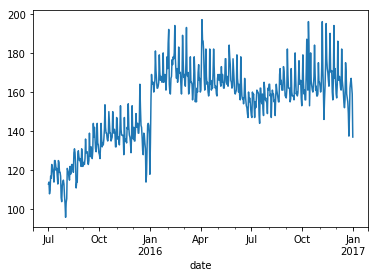

In [6]:
# plot all
data.groupby(pd.Grouper(freq='D')).Visits.median().plot()

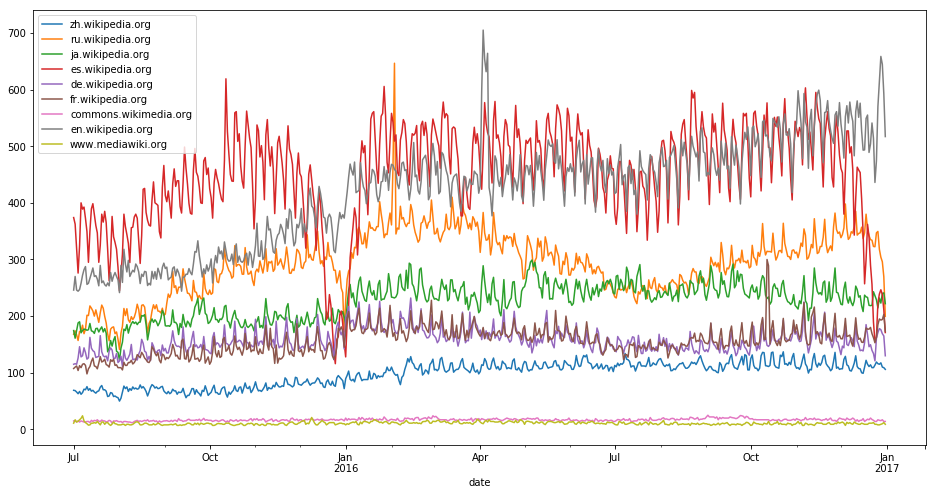

In [7]:
# plot project
plt.figure(figsize=(16,8))
for project in data.project.unique():
    data.query('project == "{}"'.format(project)).groupby(pd.Grouper(freq='D')).Visits.median().plot(label=project)
plt.legend()

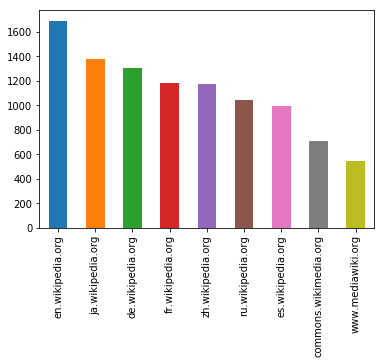

In [8]:
temp_data0.project.value_counts().plot(kind='bar')

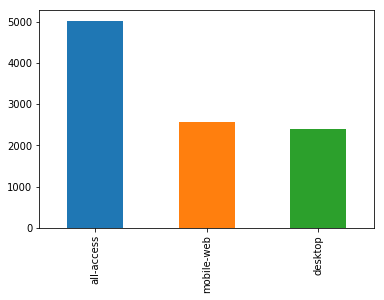

In [10]:
temp_data0.access.value_counts().plot(kind='bar')

In [11]:
ts_df = data.groupby([pd.Grouper(freq='D'),'project']).Visits.median()
ts_df = ts_df.reset_index().set_index('date')
ts_df.head()

,project,Visits
date,,
2015-07-01,commons.wikimedia.org,15.0
2015-07-01,de.wikipedia.org,115.0
2015-07-01,en.wikipedia.org,246.0
2015-07-01,es.wikipedia.org,374.0
2015-07-01,fr.wikipedia.org,107.5


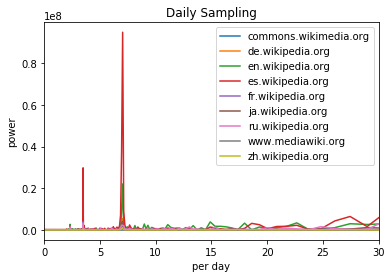

In [12]:
# power spectrum
for country in ts_df.project.unique():
    a=ts_df.query(f'project == "{country}"').Visits.rolling(30,freq='D').mean()
    b=ts_df.query(f'project == "{country}"').Visits.rolling(1,freq='D').mean()
    plt.plot(1/pd.np.fft.fftfreq(521),pd.np.abs(pd.np.fft.fft((b-a).dropna())**2), label=country)
plt.title('Daily Sampling')
plt.xlabel('per day')
plt.ylabel('power')
plt.xlim((0,30))
plt.legend()

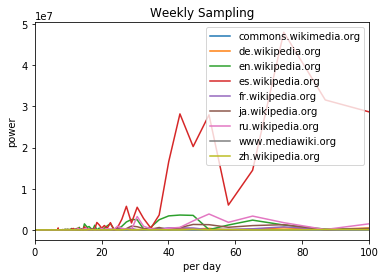

In [13]:
# power spectrum
for country in ts_df.project.unique():
    a=ts_df.query(f'project == "{country}"').Visits.rolling(30,freq='D').mean()
    b=ts_df.query(f'project == "{country}"').Visits.rolling(7,freq='D').mean()
    plt.plot(1/pd.np.fft.fftfreq(521),pd.np.abs(pd.np.fft.fft((b-a).dropna())**2), label=country)
plt.title('Weekly Sampling')
plt.xlabel('per day')
plt.ylabel('power')
plt.xlim((0,100))
plt.legend()

## Clustering

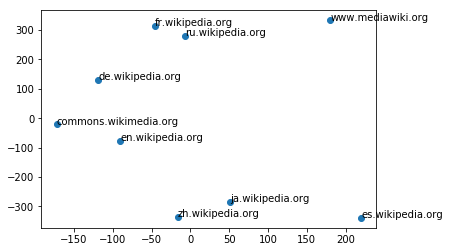

In [14]:
# correlated sites
corr_ts = ts_df.groupby([pd.Grouper(freq='D'),'project']).median().reset_index()
projects = ts_df.project.unique()
dist_mat = pd.np.zeros((projects.shape[0],projects.shape[0]))
for i,pro_i in enumerate(projects):
    for j,pro_j in enumerate(projects):
        x = corr_ts.query(f'project == "{pro_i}"').set_index('date').sort_index().Visits
        y = corr_ts.query(f'project == "{pro_j}"').set_index('date').sort_index().Visits
        x_std = (x - x.min()) / (x.max() - x.min())
        x_scaled = x_std * (1 +1) -1
        y_std = (y - y.min()) / (y.max() - y.min())
        y_scaled = y_std * (1 +1) -1
        dist_mat[i,j],_ = fastdtw(x_scaled,
                                  y_scaled, dist=euclidean)
dist_mat
# plot
mds = manifold.MDS()
pos = mds.fit_transform(dist_mat)
plt.scatter(pos[:,0], pos[:,1])
list(map(lambda s:plt.text(*s), zip(pos[:,0], pos[:,1], projects,)));

6


array([[  0.        , 161.29104859, 144.46973572],
       [161.29104859,   0.        , 114.18073316],
       [144.46973572, 114.18073316,   0.        ]])

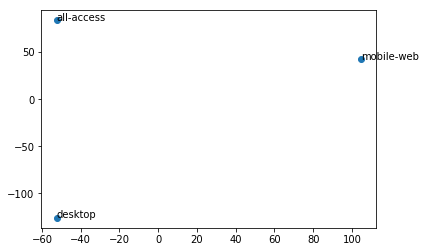

In [15]:
# correlated sites
projects = ts_df.project.unique()
project = projects[0]
agents = data.access.unique()
print(len(list(zip(*pd.np.triu_indices(agents.shape[0])))))
dist_mat = pd.np.zeros((agents.shape[0],agents.shape[0]))
x_axis, y_axis = pd.np.triu_indices(agents.shape[0])
for ij in zip(*pd.np.triu_indices(agents.shape[0])):
    if ij[0] == ij[1]:
        continue
    pro_i = agents[ij[0]]
    pro_j = agents[ij[1]]
    x = data.query(f'access == "{pro_i}"').groupby(pd.Grouper(freq='D')).Visits.median()
    y = data.query(f'access == "{pro_j}"').groupby(pd.Grouper(freq='D')).Visits.median()
    x_std = (x - x.min()) / (x.max() - x.min())
    x_scaled = x_std * (1 +1) -1
    y_std = (y - y.min()) / (y.max() - y.min())
    y_scaled = y_std * (1 +1) -1
    dist_mat[ij[0],ij[1]],_ = fastdtw(x_scaled,
                                  y_scaled, dist=euclidean)
    dist_mat[ij[1],ij[0]] = dist_mat[ij[0],ij[1]]
# plot
mds = manifold.MDS()
pos = mds.fit_transform(dist_mat)
plt.scatter(pos[:,0], pos[:,1])
list(map(lambda s:plt.text(*s), zip(pos[:,0], pos[:,1], agents,)));
dist_mat

120


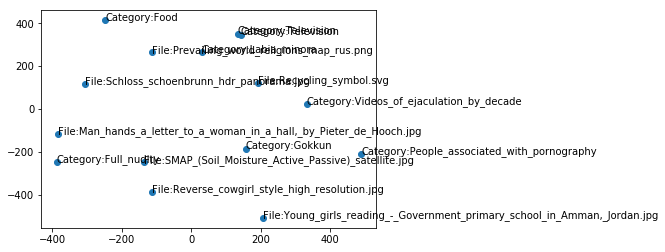

In [16]:
# cluster on name
# correlated sites
projects = ts_df.project.unique()
project = projects[0]
names = data.query(f'project == "{project}"')['name'].unique()
names = names[np.random.randint(0,names.shape[0], 15)]
print(len(list(zip(*pd.np.triu_indices(names.shape[0])))))
dist_mat = pd.np.zeros((names.shape[0],names.shape[0]))
x_axis, y_axis = pd.np.triu_indices(names.shape[0])
for ij in zip(*pd.np.triu_indices(names.shape[0])):
    if ij[0] == ij[1]:
        continue
    pro_i = names[ij[0]]
    pro_j = names[ij[1]]
    x = data.query(f'name == "{pro_i}" and project == "{project}"').sort_index().Visits
    y = data.query(f'name == "{pro_j}" and project == "{project}"').sort_index().Visits
    x_std = (x - x.min()) / (x.max() - x.min())
    x_scaled = x_std * (1 +1) -1
    y_std = (y - y.min()) / (y.max() - y.min())
    y_scaled = y_std * (1 +1) -1
    dist_mat[ij[0],ij[1]],_ = fastdtw(x_scaled.fillna(0),
                              y_scaled.fillna(0), dist=euclidean)

    dist_mat[ij[1],ij[0]] = dist_mat[ij[0],ij[1]]
dist_mat
# Plot
mds = manifold.MDS()
pos = mds.fit_transform(dist_mat)
plt.scatter(pos[:,0], pos[:,1])
list(map(lambda s:plt.text(*s), zip(pos[:,0], pos[:,1], names,)));

# Feature Engineering 

# things to do
* Lags
* spectrograms
* Variance
* weekly or natural scale

In [17]:
def features_gen(df):
    a = df.Visits.fillna(0).rolling(7,freq='D')
    df['coeff_var'] = (a.var() /a.mean())
    df['Day_of_week'] = df.index.dayofweek
    df['day']= df.index.day
    df['year']= df.index.year
    df['month'] = df.index.month
    df['target'] = df.Visits.shift(-1)
    # add lags
    df = df.join(lagmat(df.Visits, 7 ,use_pandas=True))
    df = df.dropna(subset=['Visits'])
    # drop lag period
    df = df.iloc[7:]
    df = df.fillna(0)
    # remove inf
    a = df.drop(['name', 'project', 'access', 'agent', 'Page'],axis=1).applymap(np.isinf)
    df.loc[a[a.any(1)].index, a.columns[a.any(0)]] = 99999
    return df

# Random Forest

In [18]:
loss = dict()

rfc = ensemble.RandomForestRegressor(400, warm_start=True)
for page, df in data.groupby('Page'):
    print(page)
    if df.empty:
        continue
    df = features_gen(df)
    # get ready for fit
    ts_folds = model_selection.TimeSeriesSplit()
    if df.empty or df.shape[0] <= 4:
        continue
    train_idx, test_idx  = next(ts_folds.split(df))
    rfc.fit(df.drop(['target','name', 'project', 'access', 'agent', 'Page'],axis=1).iloc[train_idx],df['target'].iloc[train_idx])
    loss[page] = [test_idx.shape[0]]
    loss[page].append(smape(df['target'].iloc[test_idx], rfc.predict(df.drop(['target','name', 'project', 'access', 'agent', 'Page'],axis=1).iloc[test_idx])))
    break

"European_Society_for_Clinical_Investigation"_en.wikipedia.org_all-access_spider


In [20]:
loss_array = np.vstack(list(loss.values())[:-1])
np.sum(loss_array[:,0] / loss_array[:,0].sum() * loss_array[:,1])

ValueError: need at least one array to concatenate

179.00272041825338

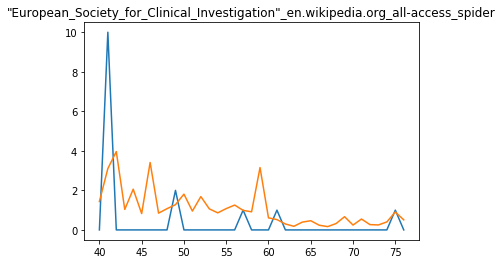

In [21]:
ts_folds = model_selection.TimeSeriesSplit()
train_idx, test_idx  = next(ts_folds.split(df))
rfc = ensemble.RandomForestRegressor(700)
rfc.fit(df.drop(['target','name', 'project', 'access', 'agent', 'Page'],axis=1).iloc[train_idx],df['target'].iloc[train_idx])
plt.plot(test_idx, df['target'].iloc[test_idx])
plt.title(page)
plt.plot(test_idx,rfc.predict(df.drop(['target','name', 'project', 'access', 'agent', 'Page'],axis=1).iloc[test_idx]))
smape(df['target'].iloc[test_idx], rfc.predict(df.drop(['target','name', 'project', 'access', 'agent', 'Page'],axis=1).iloc[test_idx]))


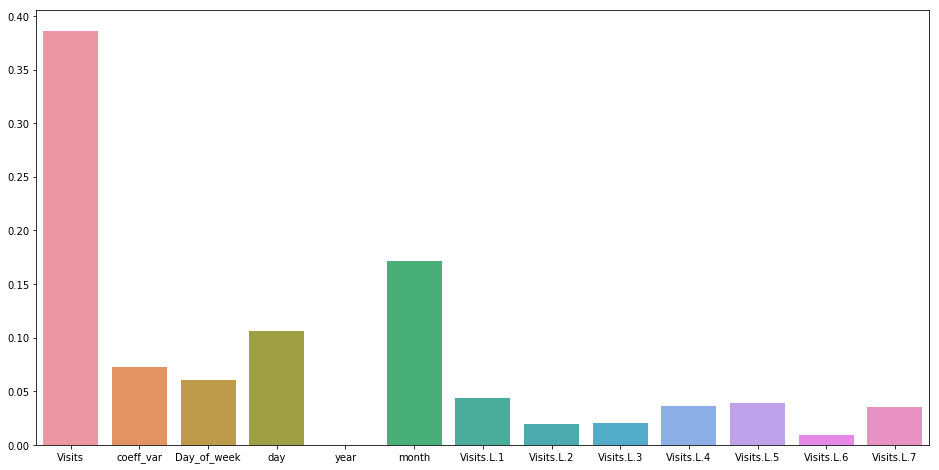

In [23]:
fig,ax = plt.subplots(figsize=(16,8))
sns.barplot(df.drop(['target','name', 'project', 'access', 'agent', 'Page'],axis=1).columns,rfc.feature_importances_,ax=ax)

# ARIMA

In [25]:
# todo: hypertuning
data_np = data.query(f"Page == '{page}'").Visits.dropna()
ts_folds = model_selection.TimeSeriesSplit()
train_idx, test_idx  = next(ts_folds.split(data_np))
model_arima = ARIMA(data_np[train_idx].values, [1,1,1])
result = model_arima.fit(disp=False)

112.10099898767008

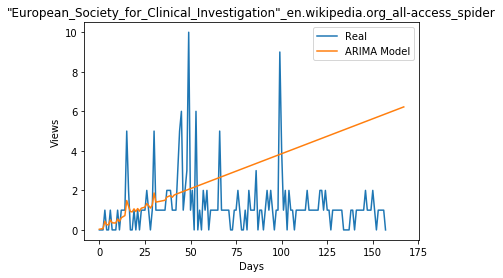

In [26]:
pred = result.predict(1,data_np.shape[0]+10,typ='levels')
x = range(data_np.shape[0]+10)
plt.plot(x[:-10],data_np ,label='Real')
plt.plot(x,pred, label='ARIMA Model')
plt.title(page)
plt.xlabel('Days')
plt.ylabel('Views')
plt.legend()
smape(data_np, pred[:-10])

# RNN

In [27]:
# design network
model_rnn = Sequential()
model_rnn.add(layers.Bidirectional(layers.GRU(8, activation = 'relu', dropout=.2,return_sequences=True),input_shape=(None, 1)))
model_rnn.add(layers.Dense(1))
model_rnn.compile(loss='mean_squared_error', optimizer='adam')
model_rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, None, 16)          480       
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


Epoch 1/100
151/151 [==============================] - 0s 175us/step - loss: 96.8651
Epoch 2/100
151/151 [==============================] - 0s 229us/step - loss: 94.4426
Epoch 3/100
151/151 [==============================] - 0s 305us/step - loss: 89.6801
Epoch 4/100
151/151 [==============================] - 0s 296us/step - loss: 86.3418
Epoch 5/100
151/151 [==============================] - 0s 305us/step - loss: 83.2084
Epoch 6/100
151/151 [==============================] - 0s 217us/step - loss: 81.5790
Epoch 7/100
151/151 [==============================] - 0s 469us/step - loss: 78.1631
Epoch 8/100
151/151 [==============================] - 0s 285us/step - loss: 78.2233
Epoch 9/100
151/151 [==============================] - 0s 350us/step - loss: 74.5258
Epoch 10/100
151/151 [==============================] - 0s 300us/step - loss: 73.3169
Epoch 11/100
151/151 [==============================] - 0s 344us/step - loss: 72.8081
Epoch 12/100
151/151 [==============================] - 0s 283u

151/151 [==============================] - 0s 308us/step - loss: 35.7619
Epoch 97/100
151/151 [==============================] - 0s 399us/step - loss: 36.6179
Epoch 98/100
151/151 [==============================] - 0s 314us/step - loss: 35.0218
Epoch 99/100
151/151 [==============================] - 0s 467us/step - loss: 35.9351
Epoch 100/100
151/151 [==============================] - 0s 470us/step - loss: 36.7004


Text(0,0.5,'loss')

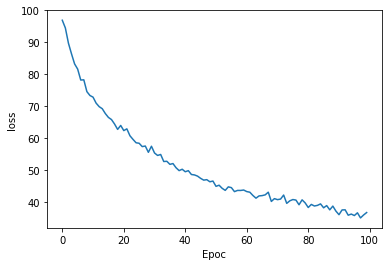

In [30]:
def reshape(df):
    df = features_gen(df)
    X_train = np.reshape(df.Visits.values,(-1,1,1))
    y_train = np.reshape(df['target'].values,(-1,1,1))
    return (X_train,y_train,)

group = data.groupby('Page')
pages = list(group.groups.keys())
pages_train = pages[:100]
pages_test = pages[100:200]
for key in pages_train:
    call = model_rnn.fit(*reshape(group.get_group(key)), epochs=100)
    break

plt.plot(call.epoch,call.history['loss'])
plt.xlabel('Epoc')
plt.ylabel('loss')

180.16059996435578

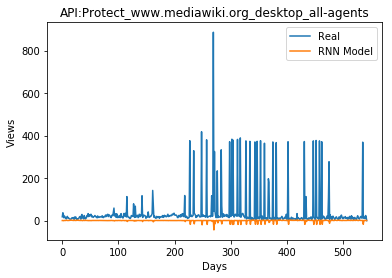

In [31]:
for key in pages_test[-9:]:
    df = group.get_group(key)
    df = features_gen(df)
    X_test = np.reshape(df.Visits.values,(-1,1,1))
    y_test = df['target'].values
    pred = model_rnn.predict(X_test)
    plt.plot(y_test ,label='Real')
    plt.plot(pred.flatten(),label='RNN Model')
    break
plt.title(key)
plt.xlabel('Days')
plt.ylabel('Views')
plt.legend()
smape(y_test, pred)